In [710]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.cm as cm
sns.set_style("whitegrid")

# A Bayesian analysis method for carbon cycle parameters
This notebook illustrates a proposed fully Bayesian method for incorporating CMIP model estimates and emergent constraints. As an example, we constrain the land carbon response to increasing temperatures ($\gamma_L$) using CMIP model simulations and the constraint on tropical $\gamma_L$ from internal variability proposed by Cox et al 2013.

## Reading in the data
Data from three generations of CMIP models is provided by Jones and Friedlingstein https://iopscience.iop.org/article/10.1088/1748-9326/ab858a

In [514]:

url = "https://docs.google.com/spreadsheets/d/14n6npj77hl-bGkNhE3wHSWS4Xt-Zd9Ww/export?format=csv&gid=99467917"
df = pd.read_csv(url,header=9)
#Optional: display the dataframe to make sure it loaded properly
display=False
if display:
    df

Split the data up by generation and read in $\gamma$ (specify whether we want land, ocean, or total)

In [515]:
variable_to_estimate = 'γL (PgC K-1)'
#variable_to_estimate = 'γtot (PgC K-1)'

split5,split6=np.where(df["model"]=="model")[0]

c4mip=df[:split5-2]
cmip5=df[split5+1:split6-2]
cmip6=df[split6+1:]

# Dictionary of γ
gammas={}
gammas["C4MIP"]=c4mip[variable_to_estimate].values.astype(np.float32)
gammas["CMIP5"]=cmip5[variable_to_estimate].values.astype(np.float32)
gammas["CMIP6"]=cmip6[variable_to_estimate].values.astype(np.float32)

### $\gamma$ over generations
Visualizing $\gamma_L$ in three model generations.  Note CMIP5 and CMIP6 estimates are less uncertain and less negative than C4MIP.

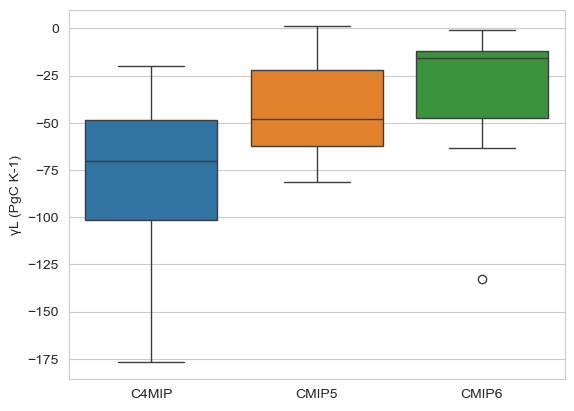

In [711]:
sns.boxplot(gammas)
tmp=plt.ylabel(variable_to_estimate)

# Estimating $\gamma$ from CMIP data
First, let's establish a Bayesian framework for combining estimates from different generations of CMIP models.
## Unavoidable choices
An analyst needs to make subjective decisions about how to combine estimates from the three generations of climate models. Do we assume all of them are equally likely to capture the ``true" value of $\gamma_L$?  Do we assume there will be a nonzero spread between different model generations?  Do we assume the CMIP models get better with time, and truest the latest generation more?  We have to make choices:
- Choosing the model: We need to select a (analytical) model to combine the results.  Here, I've chosen a simple random effects model with parameters $\mu_i$ (the latent true mean $\gamma_L$ of generation $i$), $\sigma_i$ (true standard deviation of generation $i$), $\tau$ (heterogeneity parameter representing the spread between different model generations), and the true value of $\gamma_L$.  Other models are of course possible- we might simply pool all three generations or assume earlier generations are biased.  
  
- Putting priors on the parameters: The model I've chosen requires two main prior choices: our previous knowledge about $\gamma_L$ and our knowledge about the spreac (between generations) $\tau$.

### Building the model
I assume
$$y_i \sim N(\mu_i,\sigma_i)$$
$$\mu_i \sim N(\gamma_{true},\tau)$$
$$\sigma_i \sim N^{+}(100)$$
$$\gamma_{true} \sim h(.)$$
$$\tau \sim g(.)$$
where $h(.)$ and $g(.)$ are user-specified priors

TODO: Reparametrize using $\tau^{-1}$: easier to use HalfCauchy prior 

In [633]:
def build_model(prior_dict):
    with pm.Model() as model:
        ## Specify your prior on -γ
        neg_gamma_prior=prior_dict["neg_gamma"]
        #true_gamma=pm.Deterministic("true_gamma",-1*neg_gamma)
        tau_prior = prior_dict["tau"]     # Prior on heterogeneity between CMIP generations

        #use them in the model
        true_gamma = pm.Deterministic("true_gamma",neg_gamma_prior(name='neg_gamma')*-1)
        tau = tau_prior(name="tau")
        
        #containers for generation means and sigmas
        sigmas={}
        mus={}
        obs={}
        for generation in gammas.keys():
            # prior on generation spread (doesn't really matter, could just use sample std)
            sigmas[generation]=pm.HalfNormal("sigma_"+generation, 100)#np.std(gammas[generation])
            #Each generation mean is assumed distributed about the true mean with spread tau
            mus[generation]=pm.Normal("mu_"+generation,true_gamma,tau)
            obs[generation]=pm.Normal("obs_"+generation,mus[generation],sigmas[generation],observed=gammas[generation])
    return model

### My priors
I believe $\gamma_L$ to be strictly negative and use a lognormal prior on - $\gamma_L$.  I also believe $\tau$ to be large.  I specify my priors in a dictionary of distribution factories. 

In [630]:
priors = {
    'neg_gamma': lambda name: pm.LogNormal(name, mu=np.log(50), sigma=1),
    'tau': lambda name: pm.LogNormal(name, mu=np.log(20),sigma=.2)
}

#An example of BAD priors.  
#Try using them and the sampler will get divergences- it will simply spend more time wandering aroud in unlikely parts of parameter space

# priors = {
#     'neg_gamma': lambda name: pm.Normal(name,0,1),
#     'tau': lambda name: pm.HalfNormal(name, sigma=1)
# }


Build the model and press the inference button

In [631]:
rng = np.random.default_rng(123)
kate_model=build_model(priors)
with kate_model:
    kate_trace=pm.sample(5000,tune=1000,random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [neg_gamma, tau, sigma_C4MIP, mu_C4MIP, sigma_CMIP5, mu_CMIP5, sigma_CMIP6, mu_CMIP6]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.


Visualize the posteriors.  95% of the posterior mass for $\gamma_L$ lies between (-72,-20).  $\tau$ is indeed large

array([<Axes: title={'center': 'tau'}>,
       <Axes: title={'center': 'true_gamma'}>], dtype=object)

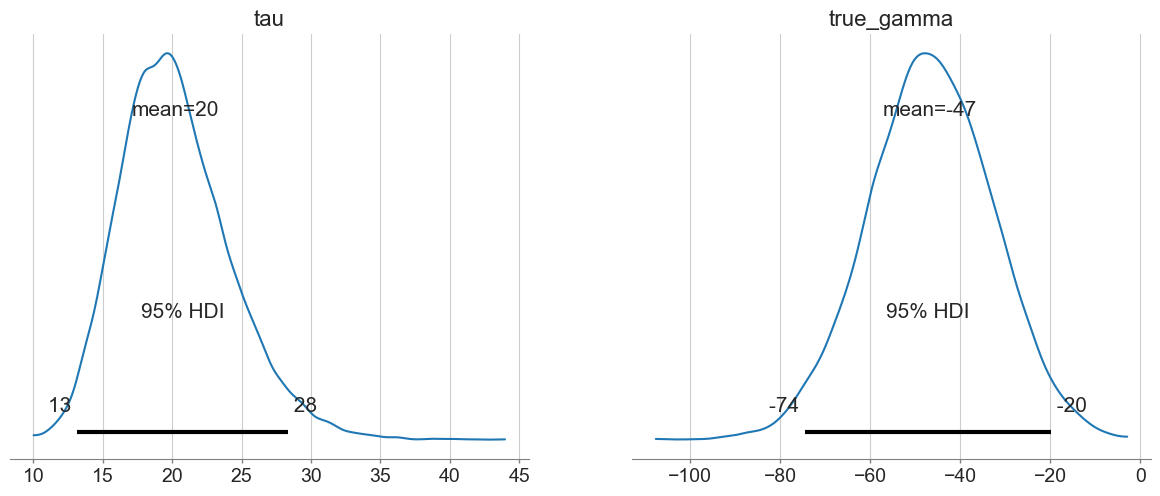

In [712]:
az.plot_posterior(kate_trace,var_names=["tau","true_gamma"],hdi_prob=.95)

# Emergent constraints
How do emergent constraints affect the estimate?  Note here we use old data (from Cox et al 2013) for illustrative purposes.

## Read in the data
Use Table S1 from Cox et al 

In [289]:
import pdfplumber

In [427]:
with pdfplumber.open("Cox2013Supp1.pdf") as pdf:
    page = pdf.pages[0]
    coxtable = page.extract_table()
cox_df = pd.DataFrame(coxtable[1:], columns=coxtable[0])
cox_df

In [461]:
#Observed IAV and uncertainties
i_obs=np.where([x.find("Obs")>=0 for x in cox_df.Model.values])[0]
observed_quantities=cox_df["IAV Sensitivity\n(ppmv/yr/K)"][i_obs].values
observed_means=[float(x.split("+")[0]) for x in observed_quantities]
observed_stds=[float(x.split("-")[1]) for x in observed_quantities]


In [ ]:
#get numbers for internal variability
iav=np.array([float(x.split("+")[0]) for x in cox_df[cox_df.columns[-1]].values])
# assumed overlap between models in cox et al 2013 and Jones and Friedlingstein
#CHRIS- please confirm that IPSL in Cox 2013 = IPSL-CM2C, CCSM1 = CSM-1, and LOOP = IPSL-CM4-LOOP
subset=["HadCM3LC","IPSL-CM2C","MPI","CSM-1","FRCGC","IPSL-CM4-LOOP"]
filtered_df=df[df["model"].isin(subset)]
order=subset
filtered_df["model"] = pd.Categorical(filtered_df["model"], categories=order, ordered=True)
sorted_df = filtered_df.sort_values("model")
gams=sorted_df["γL (PgC K-1)"].values.astype(np.float32)

## Emergent constraints from Cox 2013
The atmospheric carbon sensitivity to interannual variability appears to be related to $\gamma_L$, at least in a few C4MIP models. 

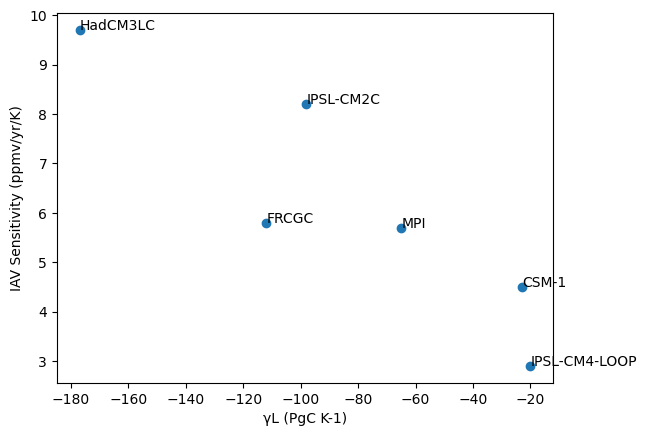

In [640]:
plt.scatter(gams,iav[:6])
for i, txt in enumerate(subset):
    plt.annotate(txt, (gams[i],iav[i]))
tmp=plt.ylabel("IAV Sensitivity (ppmv/yr/K)")
tmp=plt.xlabel("γL (PgC K-1)")

## Modeling the emergent constraint
We model IAV as linear in $\gamma_L$: 
$$IAV = m \gamma_L + b + \epsilon$$
where $\epsilon \sim N(0,\sigma)$ is the noise.  In Bayesian linear regression, this is expressed as a conditional distribution:
$$ IAV | \gamma_L \sim N(m \gamma_L+b,\sigma)$$
There are three hyperparameters: the slope of the line $m$, the intercept $b$, and the noise $\sigma$.  Note that the choice of model for the emergent constraint (here it's linear) determines the parameters $\Theta = (m,b,\sigma)$.  We'll use priors $m,b \sim N(0,10)$ and $\sigma \sim N^{+}(10)$.  You could allow users to specify these priors -- this would probably make sense for cases in which the relationship between the observable quantity and the thing to be esimated is less clear-- but here the functional form is pretty obviously linear and it won't really matter which priors we use.

In [722]:

with pm.Model() as ec_model:

    #priors on the hyperparameters m, b, sigma
    m=pm.Normal("m",0,10) 
    b=pm.Normal("b",0,10)
    sigma=pm.HalfNormal("sigma",10)
    # use the data (C4MIP IAV and gamma) to learn the hyperpriors
    D=pm.Normal("D",mu=m*gams+b,sigma=sigma,observed=iav[:6])

   
    ec_trace=pm.sample(1000,target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


## Uncertainty in the emergent constraint
Sure, the data looks pretty linear, but there's considerable uncertainty in the posterior fit.  With only five points to estimate it, the relationship between $\gamma_L$ and IAV won't be highly constrained.  Shown below is the 95\% highest-posterior-density (HPD) interval of the posterior predictive distribution (PPD).  

The PPD expresses the question "given a putative value of $\gamma_L$, what would be the IAV?  We obtain it by marginalizing over $m$, $b$, and $\sigma$:
$$ P(IAV | \gamma_L) = \int P(IAV|m,b,\sigma,D) P(m,b,\sigma|D)\,dm \, db \, d\sigma$$
where $D=\{(IAV^1,\gamma_L^1)\ldots(IAV^n,\gamma_L^n)\}$ is the training data (here C4MIP)

In [659]:
with ec_model:
    ec_ppd=pm.sample_posterior_predictive(ec_trace)

Sampling: [D]


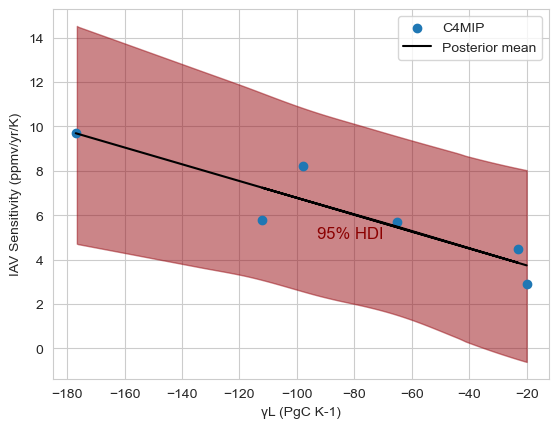

In [719]:
ax=plt.subplot(111)
az.plot_hdi(gams,ec_ppd.posterior_predictive.D,color=cm.Reds(.9))
plt.scatter(gams,iav[:6],label="C4MIP")
tmp=plt.ylabel("IAV Sensitivity (ppmv/yr/K)")
tmp=plt.xlabel("γL (PgC K-1)")
mid_x = np.median(gams)
mid_y = np.median(ec_ppd.posterior_predictive.D[:, len(x) // 2])

ax.text(mid_x, mid_y + 0.1, '95% HDI', color='darkred', ha='center', fontsize=12)
plt.plot(gams,ec_ppd.posterior_predictive.D.mean(dim=("chain","draw")).values,"k",label="Posterior mean")
plt.legend()

## Uncertainty in the observations
Let's combine observed IAV from various datasets to get a posterior estimate of the "true" IAV.  As above, we use a simple random effects meta-analysis that requires us to put priors on the true IAV and the spread $\tau$.

In [761]:



mu_i = observed_means   # reported means from studies
s_i = observed_stds    # reported standard deviations
n_datasets = len(mu_i)

with pm.Model() as meta_analysis_model:
    # Overall population mean
    mu = pm.Normal("mu", mu=np.average(observed_means), sigma=np.average(observed_stds))
    
    # Inter-study precision (heterogeneity)
    tau_obs = pm.HalfNormal("tau_obs", .1)  
    
    # True effect for each study
    theta = pm.Normal("theta", mu=mu, tau=tau_obs, shape=n_datasets)
    
    # Observed study estimates
    obs = pm.Normal("obs", mu=theta, sigma=s_i, observed=mu_i)
    
    # Sample from posterior
    iavtrace = pm.sample(2000, tune=1000, return_inferencedata=True,target_accept=.99)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau_obs, theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


### Emergent constraint
The constraint comes from assuming a linear functional relationship between $\gamma_L$ and IAV.

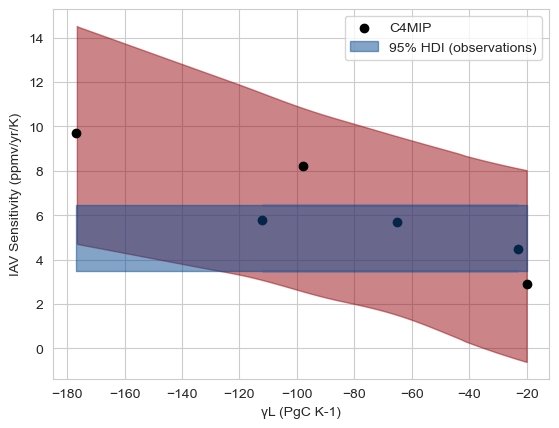

In [715]:
az.plot_hdi(gams,ec_ppd.posterior_predictive.D,color=cm.Reds(.9))
plt.scatter(gams,iav[:6],label="C4MIP",c="k")
tmp=plt.ylabel("IAV Sensitivity (ppmv/yr/K)")
tmp=plt.xlabel("γL (PgC K-1)")
low,high=az.hdi(iavtrace.posterior.mu,hdi_prob=.95).mu.values
# plt.axhline(low,ls=":",c="k")
# plt.axhline(high,ls=":",c="k")
plt.fill_between(gams,np.tile(low,len(gams)),np.tile(high,len(gams)),color=cm.Blues(.9),alpha=.5,label="95% HDI (observations)")
plt.legend()

# Putting it all together
We want $P(\gamma_L | IAV, CMIP)$.  We can use a random effects model to estimate $P(\gamma_L|CMIP)$.  We then have 
$$P(\gamma_L | IAV) = \frac{P(IAV|\gamma_L) P(\gamma_L | CMIP)}{P(IAV,CMIP)}$$
where the denominator is a normalization constant.  

To incorporate  the emergent constraint, we model $$IAV = m\gamma_L + b + \epsilon$$
where $\epsilon ~ N(0,\sigma)$ is the regression noise.  We learn the parameters $\Theta =(m,b,\sigma)$ from data $D = \{(\gamma_L^1,IAV^1)...(\gamma_L^n,IAV^n)\}$: that is, we can obtain the posterior $P(\Theta|\gamma,D)$.  We can then estimate the likelihood by marginalizing:
$$P(IAV | \gamma_L,D) = \int P(IAV|\gamma,D,\Theta) P(\Theta|\gamma,D) d\Theta$$

In plain English, this means we need to 1) combine the results of CMIP4,5,6 somehow to estimate $\gamma_L$ 2) estimate the functional form of the emergent constraint $IAV = f(\gamma_L)$ and then 3) Combine 1) and 2) to get an updated estimate.

In [757]:
prior_dict = {
    'neg_gamma': lambda name: pm.LogNormal(name, mu=np.log(50), sigma=1),
    'tau_cmip': lambda name: pm.HalfNormal(name,.0005),
    
}

In [762]:
# emergent constraint- find posteriors 
with pm.Model() as ec_model:
    ##########################################################
    # STEP 1: Estimate γ from C4MIP, CMIP5, CMIP6
    # Use this as a prior P(γ)
    ##########################################################

    neg_gamma_prior=prior_dict["neg_gamma"]
    #true_gamma=pm.Deterministic("true_gamma",-1*neg_gamma)
    tau_prior = prior_dict["tau_cmip"]     # Prior on heterogeneity between CMIP generations

    #use them in the model
    true_gamma = pm.Deterministic("true_gamma",neg_gamma_prior(name='neg_gamma')*-1)
    tau_cmip = tau_prior(name="tau_cmip")
    
    #containers for generation means and sigmas
    sigmas={}
    mus={}
    obs={}
    for generation in gammas.keys():
        # prior on generation spread (doesn't really matter, could just use sample std)
        sigmas[generation]=pm.HalfNormal("sigma_"+generation, 100)#np.std(gammas[generation])
        #Each generation mean is assumed distributed about the true mean with spread tau
        mus[generation]=pm.Normal("mu_"+generation,mu=true_gamma,tau=tau_cmip)
        obs[generation]=pm.Normal("obs_"+generation,mus[generation],sigmas[generation],observed=gammas[generation])
        
    ##########################################################
    # STEP 2: Assume γL is linearly related to IAV sensitivity.
    # Fit a simple model IAV = mγ+b+ϵ (where ϵ ~ N(0, σ)) 
    # Find posteriors for m,b,σ
    ##########################################################
    #priors on the hyperparameters m, b, sigma
    m=pm.Normal("m",0,1) 
    b=pm.Normal("b",3,1)
    sigma_regression=pm.HalfNormal("sigma_regression",10)
    # use the data (C4MIP IAV and gamma) to learn the hyperpriors
    D=pm.Normal("D",mu=m*gams+b,sigma=sigma_regression,observed=iav[:6])
    
    ##########################################################
    # STEP 3:  Get P(γ|true_IAV)
    # The true value of IAV, whatever it is, will constrain γ
    ##########################################################
    true_IAV = pm.Normal("true_IAV",mu=m*true_gamma+b,sigma=sigma_regression)

     ##########################################################
    # STEP 4:  Estimate true IAV from observations
    ##########################################################
    
    # Inter-study precision (heterogeneity)
    tau_obs = pm.HalfNormal("tau_obs", .1)  
    
    # True effect for each dataset
    theta = pm.Normal("theta", mu=true_IAV, tau=tau_obs, shape=n_datasets)
    
    # Observed study estimates
    obs = pm.Normal("obs", mu=theta, sigma=s_i, observed=mu_i)
    
    # Sample from posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True,target_accept=.99)

    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [neg_gamma, tau_cmip, sigma_C4MIP, mu_C4MIP, sigma_CMIP5, mu_CMIP5, sigma_CMIP6, mu_CMIP6, m, b, sigma_regression, true_IAV, tau_obs, theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


<Axes: title={'center': 'true_gamma'}>

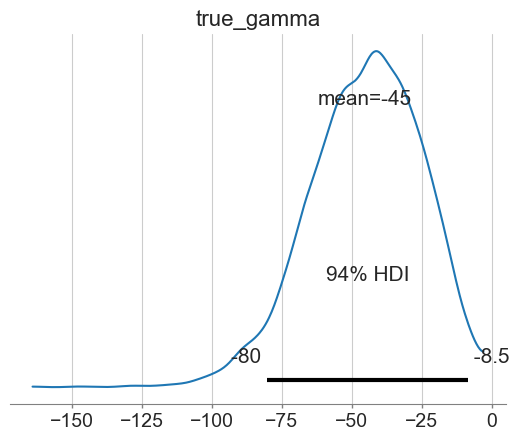

In [764]:
az.plot_posterior(trace,var_names=["true_gamma"])